### Exploration of LSTMs


In [118]:
from __future__ import print_function
import re
import urllib.request
import zipfile
import lxml.etree
import itertools
import numpy as np
import tensorflow as tf
import time
import pickle
import os
import random
import sys
import h5py
import pickle
import pandas as pd
from utils import *

from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Activation, Dropout, LSTM, GRU
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.layers.wrappers import TimeDistributed
from keras.callbacks import LearningRateScheduler
from keras import regularizers

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
time_percentage = 0.8
explained_variance = 0.9
df = pd.read_csv("data/rescuetime_data-ac-min.csv")
data_pd = Clean_DF(df)
data_pd.clean_data(time_percentage=time_percentage)
data_pd.clean_df = data_pd.clean_df.reset_index()
data_pd.get_pca(explained_variance=explained_variance)
data_pd.get_day_time()

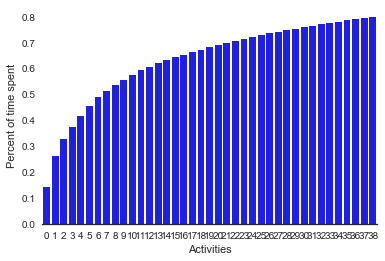

In [37]:
# Saving the objects:
# with open('data_pd_80.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump(data_pd, f)

# # Getting back the objects:
with open('data_pd_80.pickle', 'rb') as f:  # Python 3: open(..., 'rb')
    data_pd = pickle.load(f)


In [38]:
print("Dataset size:", data_pd.clean_df.shape,'\n')
print("Number of apps that consume", time_percentage*100, "% of all users time: ",len(data_pd.popular_apps), '\n')
print("Cleaned dataset columns:",'\n', data_pd.clean_df.columns.values, '\n')
print("Number of components that explain", explained_variance*100,"% of the data: ",data_pd.pca_data.shape[1], '\n')

Dataset size: (16704, 9) 

Number of apps that consume 80.0 % of all users time:  41 

Cleaned dataset columns: 
 ['Date' 'Time Spent (seconds)' 'Activity' 'Category' 'Productivity'
 'Activity Vector' 'Productivity Score' 'Day' 'Time'] 

Number of components that explain 90.0 % of the data:  18 



In [ ]:
FLAGS = tf.flags
FLAGS.look_back = 12 #lookback over a 1 hour period
FLAGS.batch_size = 10
FLAGS.inputlength = data_pd.activity_vector.shape[1]
np.random.seed(7)
dataset = data_pd.activity_vector

In [40]:
# Split text into overlapping sentences with step size 3.
def split2sequences(data, maxlen):
    print('Splitting text into sequences...')
    sequencelen = maxlen
    step = 1
    sequences = []
    response = []
    for i in range(0, len(data) - sequencelen - 1, step):
        sequences.append(data[i: i + sequencelen])
        response.append(data[i + sequencelen + 1])
    return np.array(sequences), np.array(response)

In [41]:
dataset.shape

(16704, 41)

In [42]:
# This converts the data from every row being one activity to every row being a sequence of activity
# The sequence length is determined by look_back, and for the case of 24 every row represents 
# your sequence of activities over this 2hour block

xN, yN = split2sequences(dataset, FLAGS.look_back)

Splitting text into sequences...


In [43]:
print("xN shape: ", xN.shape)
print("yN shape: ", yN.shape)

xN shape:  (16691, 12, 41)
yN shape:  (16691, 41)


In [44]:
# split into train and test sets
train_size = int(len(xN) * 0.8)
test_size = len(xN) - train_size
X_train, X_test = xN[0:train_size], xN[train_size:len(dataset)]
Y_train, Y_test = yN[0:train_size], yN[train_size:len(dataset)]

In [45]:
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)

X_train shape:  (13352, 12, 41)
Y_train shape:  (13352, 41)


In [46]:
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_test shape:  (3339, 12, 41)
Y_test shape:  (3339, 41)


## Build model

In [111]:
N_HIDDEN = 32
N_DENSE = 64
LEARNING_RATE = 0.005
DECAY = 0.001
EPOCHS = 10

In [115]:
print('Building training model...')
model = Sequential()
model.add(LSTM(N_HIDDEN, input_shape=(FLAGS.look_back, FLAGS.inputlength)))
model.add(Dropout(0.2))

model.add(Dense(N_HIDDEN, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(FLAGS.inputlength, activation='softmax'))  # Add another dense layer with the desired output size.

model.compile(loss='mean_squared_error', optimizer = RMSprop(lr=LEARNING_RATE, clipnorm=5))

print(model.summary()) # Convenient function to see details about the network model.

Building training model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_7 (LSTM)                    (None, 32)            9472        lstm_input_7[0][0]               
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 32)            0           lstm_7[0][0]                     
____________________________________________________________________________________________________
dense_16 (Dense)                 (None, 32)            1056        dropout_3[0][0]                  
____________________________________________________________________________________________________
dropout_4 (Dropout)              (None, 32)            0           dense_16[0][0]                   
________________________________________________________________

## Build inference model
Note: the inference model will have only one time step as we will feed each predicted character back into the rnn as a seed for predicting the next character. It will also be stateful so as to 'remember' previous states.

In [113]:
model.fit(x=X_train, y=Y_train, validation_data=(X_test, Y_test), nb_epoch=EPOCHS, batch_size=FLAGS.batch_size, verbose=1)

Train on 13352 samples, validate on 3339 samples
Epoch 1/1
 2124/13352 [===>..........................] - ETA: 474s - loss: 0.0109

KeyboardInterrupt: 

In [103]:
# print('Train...')
# for epoch in range(EPOCHS):
#     mean_tr_acc = []
#     mean_tr_mae = []
#     mean_tr_loss = []
#     for i in range(len(X_train)):
#         y_true = Y_train[i,:].reshape(1, FLAGS.inputlength)
#         for j in range(FLAGS.look_back):
#             x=np.expand_dims(np.expand_dims(X_train[i][j], axis=0), axis=0)
#             tr_loss, tr_acc, tr_mae = model.train_on_batch(x,y_true)
#             mean_tr_acc.append(tr_acc)
#             mean_tr_loss.append(tr_loss)
#             mean_tr_loss.append(tr_mae)
#         model.reset_states()

#     print('accuracy training = {}'.format(np.mean(mean_tr_acc)))
#     print('loss training = {}'.format(np.mean(mean_tr_loss)))
#     print('___________________________________')

#     mean_te_acc = []
#     mean_te_mae = []
#     mean_te_loss = []
#     for i in range(len(X_test)):
#         y_true = Y_train[i,:].reshape(1, FLAGS.inputlength)
#         for j in range(FLAGS.look_back):
#             tr_loss, tr_acc, tr_mae = model.test_on_batch(np.expand_dims(np.expand_dims(X_test[i][j], axis=0), axis=0), y_true)
#             mean_te_acc.append(te_acc)
#             mean_te_loss.append(te_loss)
#             mean_tr_loss.append(tr_mae)
#         model.reset_states()

#         for j in range(max_len):
#             y_pred = model.predict_on_batch(np.expand_dims(np.expand_dims(X_test[i][j], axis=0), axis=0))
#         model.reset_states()

#     print('accuracy testing = {}'.format(np.mean(mean_te_acc)))
#     print('loss testing = {}'.format(np.mean(mean_te_loss)))
#     print('___________________________________')